Make a plot to show test error as a function of data size

# Importing

In [ ]:
import copy
import calendar
from dateutil.rrule import rrule, MONTHLY
from pprint import pprint
from collections import defaultdict
import numpy as np
import pandas as pd
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as tkr
import seaborn as sns
import dill as pickle
from tpot import TPOTRegressor
from sklearn import metrics
from pymatgen.matproj.rest import MPRester
from gaspy_regress.preprocessor import GASpyPreprocessor
from gaspy import defaults, gasdb, utils

%matplotlib inline
%load_ext ipycache

In [25]:
rcParams.update({'font.sans-serif': 'Helvetica'})
rcParams.update({'font.family': 'sans-serif'})
rcParams.update({'font.size': 7})
rcParams.update({'savefig.dpi': 600})

# Regression settings

In [5]:
# Regression settings
features = ['coordatoms_chemfp0', 'neighbors_chemfp0']
dim_red = 'pca'
responses = ['energy']
blocks = ['adsorbate']
fit_blocks = [('CO',), ('H',)]
adsorbates = ['CO', 'H']
# Pull data only with these VASP settings
VASP_SETTINGS = utils.vasp_settings_to_str({'gga': 'RP',
                                            'pp_version': '5.4',
                                            'encut': 350})

# Parse our training data

In [ ]:
# Pull all of the documents and sort them by date
fingerprints = defaults.fingerprints(simulated=True)
fingerprints['symbols'] = '$atoms.chemical_symbols'  # needed for preprocessor
docs = gasdb.get_docs(fingerprints=fingerprints, **defaults.doc_filters())
docs = sorted(docs, key=lambda doc: doc['adslab_calculation_date'])

# Initialize a dictionary whose keys are the mpids we've studied
# and whose values are their compositions. This can be used to filter
# the documents
mpids = set(doc['mpid'] for doc in docs)
compositions_by_mpid = dict.fromkeys(mpids)
# Open up MP connection
mp_key = utils.read_rc('matproj_api_key')
with MPRester(mp_key) as mp_db:
    # Populate that dictionary, `compositions_by_mpid`
    for mpid in tqdm.tqdm(mpids):
        entry = mp_db.get_entry_by_material_id({'task_ids': mpid})
        comp = set(entry.as_dict()['composition'].keys())
        compositions_by_mpid[mpid] = set(comp)

# Define the elements to exclude from our study
excluded_elements = set(['Ca', 'Na', 'Nb', 'S', 'Se'])
# Use the `compositions_by_mpid` dictionary to identify the mpid numbers to exclude.
mpids_to_exclude = []
for mpid, comp in compositions_by_mpid.iteritems():
    if excluded_elements.intersection(comp):
        mpids_to_exclude.append(mpid)
mpids_to_exclude = set(mpids_to_exclude)

# Finally, reconstruct docs to exclude the elements
docs = [doc for doc in docs if doc['mpid'] not in mpids_to_exclude]
# Add a key to the docs that we're probably going to need
for i, doc in enumerate(docs):
    ads = doc['adsorbates'][0]
    docs[i]['adsorbate'] = ads

# Perform regression

In [7]:
%%cache errors.pkl dfs

# Decide how big each test set should be
test_size = 200

# Pull out the correct adsorbate data and initialize the output dataframes
dfs = dict.fromkeys(adsorbates)
for ads in adsorbates:
    ads_docs = [doc for doc in docs if ads in doc['adsorbates']]
    # We'll eventually be storing the data in a Pandas dataframe.
    # Here we initialize the dictionary that'll be used to construct the dataframe
    data = defaultdict(list)

    # Get the correct data
    n_splits = len(ads_docs) // test_size
    #for split_number in reversed(range(1, n_splits+1)):
    for split_number in range(1, n_splits+1):
        split_docs = ads_docs[:test_size*(split_number+1)]
        training_size = len(split_docs) - test_size

        # If we've already done this point, just open it
        try:
            with open('models/%s_%i.pkl' % (ads, training_size), 'rb') as f_handle:
                pp, tpot, train_errors, test_errors = pickle.load(f_handle)

        # Otherwise fit the regressor and save it
        except IOError:
            # Initialize the preprocessing pipeline
            pp = GASpyPreprocessor(docs=split_docs[:-test_size],
                                   features=features, dim_red=dim_red)
            tpot = TPOTRegressor(
                                 generations=1,
                                 population_size=16,
                                 offspring_size=16,
                                 verbosity=2,
                                 #random_state=42,
                                 scoring='neg_median_absolute_error',
                                 #scoring='neg_mean_absolute_error',
                                 #scoring='neg_mean_squared_error',
                                 n_jobs=16,
                                )
            # Establish the training data and then train
            x = pp.transform(split_docs)
            y = np.array([doc['energy'] for doc in split_docs])
            x_train = x[:-test_size]
            y_train = y[:-test_size]
            tpot.fit(x_train, y_train)
            # Make predictions then calculate errors
            y_pred = tpot.predict(x)
            y_test = y[-test_size:]
            train_errors = y_pred[:-test_size] - y_train
            test_errors = y_pred[-test_size:] - y_test
            # Pickle the preprocessor, model, and errors
            tpot = tpot.fitted_pipeline_
            with open('models/%s_%i.pkl' % (ads, training_size), 'wb') as f_handle:
                pickle.dump((pp, tpot, train_errors, test_errors), f_handle)

        # Report the results
        print('For %s and given a training set with %i points, we get:\n%s\n'
              % (ads, training_size, tpot.steps))
        # Store the test documents along with their errors
        for doc in split_docs[-test_size:]:
            for key, value in doc.iteritems():
                data[key].append(value)
        data['Error [eV]'].extend(test_errors)
    # Create the dataframe
    dfs[ads] = pd.DataFrame(data)

[Skipped the cell's code and loaded variables dfs from file '/global/project/projectdirs/m2755/manuscripts/GASpy/figures/hits/errors.pkl'.]
For CO and given a training set with 200 points, we get:
[('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=83, p=1,
          weights='distance'))]

For CO and given a training set with 400 points, we get:
[('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=2,
          weights='distance'))]

For CO and given a training set with 600 points, we get:
[('stackingestimator-1', StackingEstimator(estimator=ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.85, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001

  9%|▉         | 143/1523 [00:30<04:49,  4.76it/s]

# Plotting convergence of performance

## Parse data
We'll eventually be plotting the number of hits. We know if a site is a "hit" based on whether or not it shows up as the representative site in the databall of surfaces. Let's import that databall and then find all of the pertinent mongo IDs of hits.

In [8]:
# Set ranges
hit_ranges = dict(CO=(-0.77, -0.57), H=(-0.37, -0.17))

# Pull the databalls
hits_mongo_ids = []
for file_name in ['../CO2RR_predictions.pkl', '../HER_predictions.pkl']:
    with open(file_name, 'rb') as file_handle:
        dft_results, ml_results = pickle.load(file_handle)
    # Sift through all of the DFT data and find surfaces
    # that are within the ideal bounds
    for doc, _, _ in dft_results:
        lower_bound, upper_bound = hit_ranges[doc['adsorbates'][0]]
        if lower_bound < doc['energy'] < upper_bound:
            hits_mongo_ids.append(doc['mongo_id'])
# Convert to set for fast parsing
hits_mongo_ids = set(hits_mongo_ids)

def check_for_hit(row, ads):
    '''
    Here we make a function that'll help us look at and modify the
    dataframe to tell us if something is a hit

    Inputs:
        row     Pandas dataframe row
        ads     String indicating the adsorbate you're looking at
    Output:
        Boolean indicating whether that row is a hit or not
    '''
    lower_bound, upper_bound = hit_ranges[ads]
    if str(row['mongo_id']) in hits_mongo_ids:
        return True
    else:
        return False

## Plot

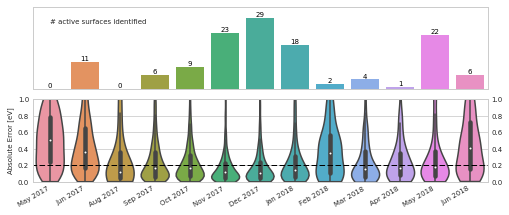

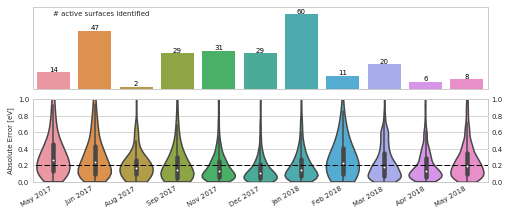

In [39]:
# Plot settings
figsize = (7.08661, 3.0)   # 7.08661 is 180 mm in inches (required by Nature)
#figsize = (3.46457, 3.0)   # 3.46457 is 88 mm in inches (required by Nature)
ylim = (0, 1)
yticks = [0., 0.2, 0.4, 0.6, 0.8, 1.0]
sns.set_style('whitegrid')
color = 'gray'

# Make a plot for each adsorbate
for ads in adsorbates:
    df = dfs[ads]

    # Use the calculation date to bucket everything
    # into readable month/year strings
    readable_dates = []
    for time in df['adslab_calculation_date']:
        month = time.strftime('%b')
        year = str(time.year)
        readable_dates.append(month + ' ' + year)
    df['Date'] = readable_dates
    # Initialize subplotting, since we're going to have both hits and
    # error distributions vs. time
    fig, axes = plt.subplots(2, figsize=figsize, sharex=True)
    ax_hits, ax_dist = axes
    # Push the subplots together
    plt.subplots_adjust(wspace=0, hspace=0.05)

    # Convert errors into absolute errors
    df['Absolute Error [eV]'] = np.abs(df['Error [eV]'])
    # Create and format the distribution plot
    ax_dist = sns.violinplot(x='Date', y='Absolute Error [eV]', data=df,
                             ax=ax_dist, cut=0, scale='width')
    plt.xticks(rotation=30, ha='right')
    ax_dist.set_xlabel('')
    ax_dist.set_ylim((ylim))
    ax_dist.set_yticks(yticks)
    ax_dist.tick_params(labelright=True)
    # Add dashed line
    ax_dist.plot([-1, 13], [0.2, 0.2], 'k--', linewidth=1)

    # Mark whether or not data is a "hit"
    df['Hits'] = df.apply(lambda row: check_for_hit(row, ads), axis=1)
    # Figure out the months/bins to plot by
    months = [label.get_text() for label in ax_dist.get_xticklabels()]
    # Calculate the counts within each bin
    hits = [0]*len(months)
    for m, month in enumerate(months):
        for date, hit in zip(df['Date'], df['Hits']):
            if hit and date == month:
                hits[m] += 1
    # Create the hits plot
    ax_hits = sns.barplot(x=months, y=hits, ax=ax_hits)
    # Label the actual number of hits on top of the bars
    for tick, hit in zip(range(len(months)), hits):
        ax_hits.text(x=tick, y=hit+0.5, s=hit, horizontalalignment='center', color='k')
    # Misc formatting for the hits plot
    ax_hits.set_yticks([])
    low_ylim, high_ylim = ax_hits.get_ylim()
    if ads == 'CO':
        ax_hits.text(0, high_ylim-4, '# active surfaces identified')
    elif ads == 'H':
        ax_hits.text(0, high_ylim-4, '# active surfaces identified')
    ax_hits.set_ylim((low_ylim, high_ylim+3))

    # Save
    plt.tight_layout()
    plt.savefig('conv_for_%s.pdf' % ads, transparent=True, bbox_inches='tight')

# Calculating performance

In [11]:
# Pull out the error data for each adsorbate
for ads in adsorbates:
    df = dfs[ads]
    errors = df['Error [eV]']
    # Calculate metrics from the errors
    y_true = np.zeros(len(errors))
    y_pred = errors
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mad = metrics.median_absolute_error(y_true, y_pred)
    # Report
    print('For %s:' % ads)
    print('    RMSE = %.2f' % rmse)
    print('    MAE = %.2f' % mae)
    print('    MAD = %.2f' % mad)

For CO:
    RMSE = 0.46
    MAE = 0.29
    MAD = 0.17
For H:
    RMSE = 0.41
    MAE = 0.24
    MAD = 0.16
